In [164]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [165]:
# Read dataset
df = pd.read_csv('Model_Ready_Traffic_Data.csv')

# Preview dataset
df.head()

,Date,Hour,Junction,Vehicles,temp_norm,humidity_norm,precip_norm,windspeed_norm,DateTime,Vehicles_lag_1,...,Event_Name,Event_Type,temp_norm_raw,humidity_norm_raw,precip_norm_raw,windspeed_norm_raw,Day_of_Week,Month,Is_Weekend,Event_Flag
0,2015-11-02,0,1,14,0.481928,0.814757,0.471408,0.020339,2015-11-02 00:00:00,15.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
1,2015-11-02,1,1,12,0.481928,0.814757,0.471408,0.020339,2015-11-02 01:00:00,14.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
2,2015-11-02,2,1,14,0.481928,0.814757,0.471408,0.020339,2015-11-02 02:00:00,12.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
3,2015-11-02,3,1,12,0.481928,0.814757,0.471408,0.020339,2015-11-02 03:00:00,14.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
4,2015-11-02,4,1,12,0.481928,0.814757,0.471408,0.020339,2015-11-02 04:00:00,12.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1


In [166]:
print(df.columns)

Index(['Date', 'Hour', 'Junction', 'Vehicles', 'temp_norm', 'humidity_norm',
       'precip_norm', 'windspeed_norm', 'DateTime', 'Vehicles_lag_1',
       'Vehicles_lag_2', 'Vehicles_lag_24', 'DateTime_raw', 'Time',
       'Vehicles_raw', 'ID', 'temp', 'humidity', 'precip', 'windspeed',
       'weather conditions', 'Event_Name', 'Event_Type', 'temp_norm_raw',
       'humidity_norm_raw', 'precip_norm_raw', 'windspeed_norm_raw',
       'Day_of_Week', 'Month', 'Is_Weekend', 'Event_Flag'],
      dtype='object')


In [167]:
# Ensure DateTime is in proper datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = pd.to_datetime(df['Date'])

In [168]:
# Speed data was not available in the provided dataset

# Create synthetic speed variable

# Free-flow speed = 40 km/h
# Max reduction = 20 km/h
max_vehicles = df['Vehicles'].max()

df['Estimated_Speed'] = 40 - (df['Vehicles'] / max_vehicles) * 20

# Ensure speed never goes below 5 km/h
df['Estimated_Speed'] = df['Estimated_Speed'].clip(lower=5)

## TASK 1: PEAK HOUR IDENTIFICATION & PATTERN ANALYSIS

### Calculate Congestion Metrics

In [169]:
# Metric 1: Average vehicles per hour across all days
vehicles_hourly = df.groupby('Hour')['Vehicles'].mean()
vehicles_hourly

Hour
0     45.789127
1     39.199341
2     33.947282
3     29.467875
4     25.682043
5     24.097199
6     26.108731
7     29.561779
8     32.771005
9     39.047776
10    49.584843
11    56.252059
12    57.322900
13    51.135091
14    54.797364
15    54.288303
16    51.976936
17    51.911038
18    55.474465
19    58.868204
20    57.467875
21    54.596376
22    53.018122
23    50.146623
Name: Vehicles, dtype: float64

In [170]:
# Metric 2: Congestion score = combination of multiple factors
df['Congestion_Score'] = (
    df['Vehicles'] * 0.6 +
    (40 - df['Estimated_Speed']) * 0.2 +   # speed reduction factor
    df['temp_norm'] * 0.05 +
    df['humidity_norm'] * 0.05 +
    df['precip_norm'] * 0.05 +
    df['windspeed_norm'] * 0.05
)

congestion_hourly = df.groupby('Hour')['Congestion_Score'].mean().sort_values(ascending=False)

In [171]:
congestion_hourly.head()

Hour
19    36.881037
20    36.004934
12    35.914231
11    35.244270
18    34.757774
Name: Congestion_Score, dtype: float64

In [172]:
# Moving Averages for Stability

df['MA_3hr'] = df['Congestion_Score'].rolling(window=3).mean()
df['MA_6hr'] = df['Congestion_Score'].rolling(window=6).mean()

##### IDENTIFY PEAK HOURS

In [173]:
# Using moving average to smooth noise
hourly_smooth = congestion_hourly.rolling(window=3, min_periods=1).mean()

In [174]:
# Top 5 peak hours
top_peak_hours = hourly_smooth.sort_values(ascending=False).head(5)
print("\nTop Peak Hours (Based on Congestion Score):")
print(top_peak_hours)


Top Peak Hours (Based on Congestion Score):
Hour
19    36.881037
20    36.442985
12    36.266734
11    35.721145
18    35.305425
Name: Congestion_Score, dtype: float64


In [175]:
# Standard Deviation-Based Peak Detection

std_hourly = df.groupby('Hour')['Congestion_Score'].std()
print("\nHourly Standard Deviation:\n", std_hourly)


Hourly Standard Deviation:
 Hour
0     11.367857
1      9.717411
2      8.548660
3      7.544126
4      6.500855
5      6.099922
6      6.933748
7      7.844105
8      8.666991
9      9.690105
10    12.535276
11    15.301602
12    15.853388
13    13.815257
14    15.752659
15    15.567245
16    14.677282
17    14.546372
18    15.338305
19    15.604482
20    15.007214
21    14.136398
22    13.381403
23    12.467356
Name: Congestion_Score, dtype: float64


In [176]:
# PEAK HOURS — PER JUNCTION

print("\nTOP PEAK HOURS FOR EACH JUNCTION:")
peak_by_junction = (
    df.groupby(["Junction","Hour"])["Congestion_Score"]
      .mean()
      .groupby("Junction")
      .nlargest(3)
)
print(peak_by_junction)


TOP PEAK HOURS FOR EACH JUNCTION:
Junction  Junction  Hour
1         1         19      36.881037
                    20      36.004934
                    12      35.914231
Name: Congestion_Score, dtype: float64


In [177]:
# Identify Consistent Peak Hours

mean_congestion = hourly_smooth.mean()
std_congestion = hourly_smooth.std()

consistent_peak_hours = hourly_smooth[hourly_smooth > (mean_congestion + std_congestion)]
print("\nConsistent Peak Hours (Mean + 1 STD Rule):\n", consistent_peak_hours)


Consistent Peak Hours (Mean + 1 STD Rule):
 Hour
19    36.881037
20    36.442985
12    36.266734
Name: Congestion_Score, dtype: float64


In [178]:
# TEMPORAL PATTERNS (DAY/WEEK/MONTH)

# Day of week (0 = Monday)
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Weekend flag
df['Is_Weekend'] = df['Day_of_Week'].isin([5,6])

# Monthly
df['Month'] = df['Date'].dt.month

# Avg congestion by weekday/weekend
weekday_pattern = df.groupby('Day_of_Week')['Congestion_Score'].mean()

# Weekend vs Weekday
weekend_vs_weekday = df.groupby("Is_Weekend")['Congestion_Score'].mean()

# Monthly pattern
monthly_pattern = df.groupby('Month')['Congestion_Score'].mean()

In [179]:
weekday_pattern

Day_of_Week
0    30.960763
1    32.109645
2    31.872958
3    31.511071
4    29.482025
5    21.391300
6    20.392717
Name: Congestion_Score, dtype: float64

In [180]:
weekend_vs_weekday

Is_Weekend
False    31.187292
True     20.892009
Name: Congestion_Score, dtype: float64

In [181]:
monthly_pattern

Month
1     25.844544
2     28.816984
3     29.195827
4     29.374679
5     32.532653
6     34.522036
7     24.541721
8     26.282732
9     29.924873
10    31.346504
11    23.306324
12    23.127102
Name: Congestion_Score, dtype: float64

In [182]:
# INFLUENCING FACTORS (Weather → Congestion Correlation)
weather_cols = ['Vehicles','temp','humidity','precip','windspeed']
weather_corr = df[weather_cols + ['Congestion_Score']].corr()['Congestion_Score']
print("\nCorrelation with Congestion Score:")
print(weather_corr.sort_values(ascending=False))


Correlation with Congestion Score:
Congestion_Score    1.000000
Vehicles            1.000000
windspeed           0.107211
temp                0.009085
precip             -0.022697
humidity           -0.137819
Name: Congestion_Score, dtype: float64


In [183]:
# Event impact (None=0, Event=1)
event_impact = df.groupby("Event_Flag")['Congestion_Score'].mean()
event_impact

Event_Flag
1    28.270013
Name: Congestion_Score, dtype: float64

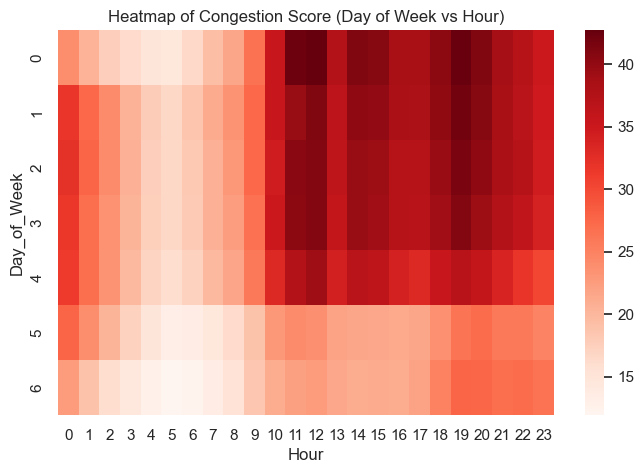

In [184]:
# VISUALISATIONS

# 1. HOURLY PEAK HEATMAP (Hour vs Day of Week)
pivot_hour_day = df.pivot_table(values='Congestion_Score', index='Day_of_Week', columns='Hour', aggfunc='mean')

plt.figure(figsize=(8,5))
sns.heatmap(pivot_hour_day, cmap='Reds')
plt.title("Heatmap of Congestion Score (Day of Week vs Hour)")
plt.show()

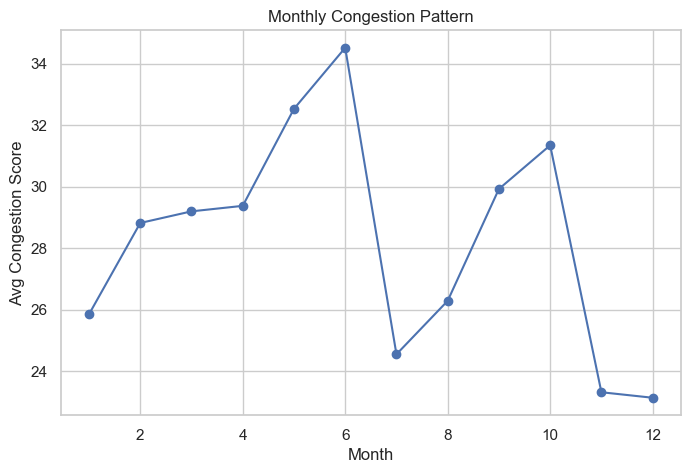

In [185]:
# 2. MONTHLY PATTERN LINE PLOT
plt.figure(figsize=(8,5))
plt.plot(monthly_pattern.index, monthly_pattern.values, marker='o')
plt.title("Monthly Congestion Pattern")
plt.xlabel("Month")
plt.ylabel("Avg Congestion Score")
plt.grid(True)
plt.show()

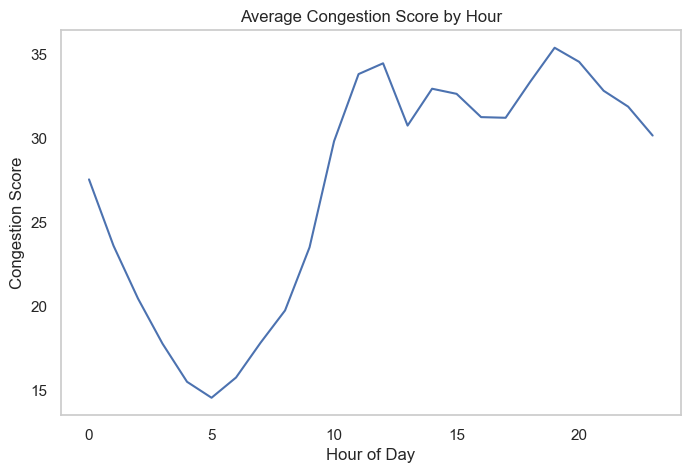

In [186]:
# 3. HOURLY AVERAGE CONGESTION LINE PLOT
plt.figure(figsize=(8,5))
sns.lineplot(x=hourly_congestion.index, y=hourly_congestion.values)
plt.title("Average Congestion Score by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Congestion Score")
plt.grid()
plt.show()

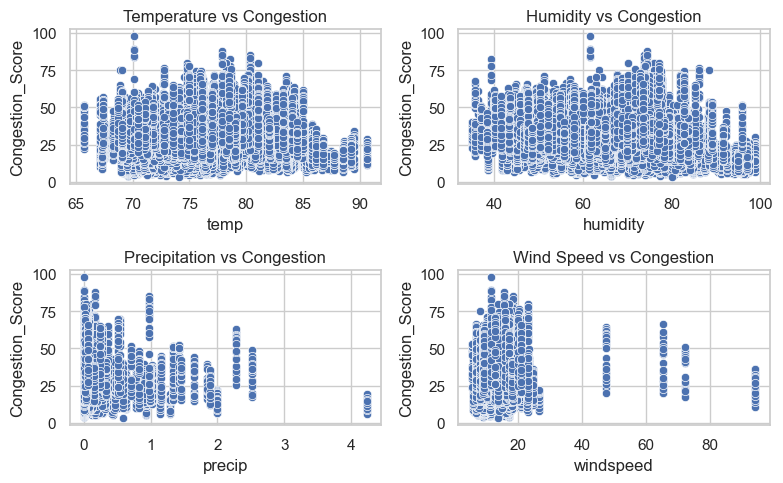

In [187]:
# 4. WEATHER IMPACT SCATTER PLOTS
fig, axes = plt.subplots(2,2, figsize=(8,5))
sns.scatterplot(data=df, x='temp', y='Congestion_Score', ax=axes[0,0])
axes[0,0].set_title("Temperature vs Congestion")

sns.scatterplot(data=df, x='humidity', y='Congestion_Score', ax=axes[0,1])
axes[0,1].set_title("Humidity vs Congestion")

sns.scatterplot(data=df, x='precip', y='Congestion_Score', ax=axes[1,0])
axes[1,0].set_title("Precipitation vs Congestion")

sns.scatterplot(data=df, x='windspeed', y='Congestion_Score', ax=axes[1,1])
axes[1,1].set_title("Wind Speed vs Congestion")

plt.tight_layout()
plt.show()

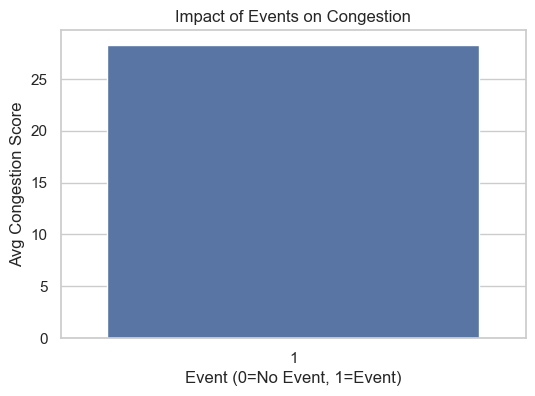

In [188]:
# 5.Event impact
plt.figure(figsize=(6,4))
sns.barplot(x=event_impact.index, y=event_impact.values)
plt.title("Impact of Events on Congestion")
plt.xlabel("Event (0=No Event, 1=Event)")
plt.ylabel("Avg Congestion Score")
plt.show()


In [189]:
print("\n------------------- FINAL ANALYSIS REPORT -------------------")
print("\nTop Peak Hours:")
print(top_peak_hours)

print("\nHourly Standard Deviation (Variability):")
print(std_hourly.sort_values(ascending=False))

print("\nDay-of-Week Congestion Pattern:")
print(weekday_pattern)

print("\nWeekend vs Weekday Congestion:")
print(weekend_vs_weekday)

print("\nMonthly Congestion Pattern:")
print(monthly_pattern)

print("\nWeather Correlation with Congestion Score:")
print(weather_corr)

print("\nEvent Impact on Congestion:")
print(event_impact)

print("\nReport Generated Successfully.")


------------------- FINAL ANALYSIS REPORT -------------------

Top Peak Hours:
Hour
19    36.881037
20    36.442985
12    36.266734
11    35.721145
18    35.305425
Name: Congestion_Score, dtype: float64

Hourly Standard Deviation (Variability):
Hour
12    15.853388
14    15.752659
19    15.604482
15    15.567245
18    15.338305
11    15.301602
20    15.007214
16    14.677282
17    14.546372
21    14.136398
13    13.815257
22    13.381403
10    12.535276
23    12.467356
0     11.367857
1      9.717411
9      9.690105
8      8.666991
2      8.548660
7      7.844105
3      7.544126
6      6.933748
4      6.500855
5      6.099922
Name: Congestion_Score, dtype: float64

Day-of-Week Congestion Pattern:
Day_of_Week
0    30.960763
1    32.109645
2    31.872958
3    31.511071
4    29.482025
5    21.391300
6    20.392717
Name: Congestion_Score, dtype: float64

Weekend vs Weekday Congestion:
Is_Weekend
False    31.187292
True     20.892009
Name: Congestion_Score, dtype: float64

Monthly Congesti